<a href="https://colab.research.google.com/github/OoJackoO/MMAI894_Deep-Learning-Course-Project/blob/dev/MMAI894_Tomato_Disease_CLS_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading & Loading the Dataset

In [ ]:
# !pip install -q kaggle
# ! mkdir ~/content/drive/My Drive/Colab Notebooks/MMAI 894
# ! cp kaggle.json ~/content/drive/My Drive/Colab Notebooks/MMAI 894/
# ! chmod 600 ~/kaggle/kaggle.json

In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')

In [ ]:
# Set the directory to where you want to have your dataset & jason authentication file
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset"
# %cd /content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset/

In [ ]:
# from kaggle.api.kaggle_api_extended import KaggleApi
# import zipfile

In [ ]:
# # this will prompt you to upload the kaggle.json
# from google.colab import files

# files.upload() 

In [ ]:
# # Check if your jason file is there and authentication is successful
# api = KaggleApi()
# api.authenticate()
# !ls -lha kaggle.json

In [ ]:
# # ! kaggle competitions download google-smartphone-decimeter-challenge
# !kaggle datasets download -d cookiefinder/tomato-disease-multiple-sources
# with zipfile.ZipFile('tomato-disease-multiple-sources.zip', 'r') as zip_ref:
#         zip_ref.extractall('./')

# Tomato Leaf Disease

In [91]:
import os
import numpy as np
import pandas as pd

import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
import glob
import cv2

from skimage.io import imread
from skimage.transform import resize
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

import warnings
warnings.filterwarnings('ignore')

import zipfile
from google.colab import drive
from PIL import ImageFile

import PIL
import PIL.Image

from pathlib import Path
import imghdr

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Set the directory to your specific folder in Google Drive
folder_path = "/content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset/"

# Check if the directory exists and print the list of files and folders inside it
if os.path.exists(folder_path):
    files = os.listdir(folder_path)
    print(files)
else:
    print("Directory does not exist.")

root_dir = "/content/drive/My Drive/" 
# choose where you want your project files to be saved
project_folder = "Colab Notebooks/MMAI 894/Dataset/"
os.chdir(root_dir + project_folder)

Mounted at /content/drive
['tomato-disease-multiple-sources.zip', 'train', 'valid']


In [3]:
!pwd

/content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset


In [4]:
main_dir = os.getcwd()
train_dir = os.path.join(main_dir, 'train')
val_dir = os.path.join(main_dir, 'valid')

https://www.tensorflow.org/tutorials/load_data/images

In [54]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=os.listdir(train_dir),
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=24,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    )

Found 25821 files belonging to 11 classes.


In [55]:
Original_val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=24,
    validation_split=0.5,
    subset='both',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    )

Found 6677 files belonging to 11 classes.
Using 3339 files for training.
Using 3338 files for validation.


In [56]:
val_ds = Original_val_ds[0]
test_ds = Original_val_ds[1]

In [57]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 11)


In [9]:
class_names = train_ds.class_names
print(class_names)

['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']


https://stackoverflow.com/questions/68191448/unknown-image-file-format-one-of-jpeg-png-gif-bmp-required

https://www.tensorflow.org/tutorials/load_data/images

https://stackoverflow.com/questions/65438156/tensorflow-keras-error-unknown-image-file-format-one-of-jpeg-png-gif-bmp-re

Need to check if the images are properly formatted and ready to be used.

In [ ]:
data_dir = train_dir
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png", 'jpg']
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

/content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset/train/Early_blight/early-blight-tomato-causal-agents-260nw-1746486380.jpg is not an image
/content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset/train/Early_blight/EB_(976).jpg is not an image
/content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset/train/Early_blight/220px-Alternaria_solani_-_leaf_lesions.jpg is not an image
/content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset/train/Leaf_Mold/BM_(6).jpg is not an image
/content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset/train/Leaf_Mold/BM_(7).jpg is not an image
/content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset/train/Leaf_Mold/BM_(975).jpg is not an image
/content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset/train/Leaf_Mold/BM_(976).jpg is not an image
/content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset/train/Leaf_Mold/BM_(98).jpg is not an image
/content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset/train/Leaf_Mold/607-155-1.jpg is not an image
/cont

In [ ]:
#JPEG, PNG, GIF, BMP
data_dir = val_dir
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png", 'jpg']
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

/content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset/valid/Leaf_Mold/607-155-0.jpg is not an image
/content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset/valid/healthy/tomato-leaf-isolated-on-white-260nw-1167806389.jpg is not an image
/content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset/valid/healthy/tomato-leaves-isolated-on-white-260nw-1251320371.jpg is not an image
/content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset/valid/healthy/tomato-leaves-isolated-on-white-260nw-1313938871.jpg is not an image


In [108]:
params = {
          'RANDOM_STATE': 24,
          'TRAINABLE': False,
          'DENSE_ACTIVATION':'relu',
          'DROPOUT_RATE':0.6,
          'LEARNING_RATE': 5e-4,
          'LEARNING_RATE_DECAY':False,
          'CHECKPOINT':True,
          'EPOCHS':100,
}

In [120]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),

  tf.keras.layers.Conv2D(128, 3, activation=params['DENSE_ACTIVATION']),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(128, 3, activation=params['DENSE_ACTIVATION']),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(128, 3, activation=params['DENSE_ACTIVATION']),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation=params['DENSE_ACTIVATION']),

  tf.keras.layers.Dropout(params['DROPOUT_RATE']),
  tf.keras.layers.Dense(num_classes, activation="softmax"),
])

# Build the model by calling the build() method
model.build(input_shape=(None, 224, 224, 3))

In [121]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 109, 109, 128)     147584    
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 54, 54, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 52, 52, 128)     

In [123]:
optimizer = keras.optimizers.Adam(learning_rate=params['LEARNING_RATE']) 
model.compile(
  optimizer=optimizer,
  loss=categorical_crossentropy,
  metrics=['accuracy'])

In [117]:
# early stopping 
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min',
    restore_best_weights=True,
    patience=7, 
    verbose=1
)

# check point - save best model
check_point = ModelCheckpoint(filepath='../model/cnn_best_1.hdf5',
                                          monitor='val_loss',
                                          mode='min',
                                          save_best_only=True
                                          )


# learning rate schedule
lr_start = 0.01

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr_start, params['EPOCHS'])
lr_scheduler = LearningRateScheduler(exponential_decay_fn)
     

callbacks = [early_stopping]

if params['CHECKPOINT']:
  callbacks.append(check_point)
if params['LEARNING_RATE_DECAY']:
  callbacks.append(lr_scheduler)

callbacks

In [124]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks = callbacks,
  epochs=params['EPOCHS']
)

Epoch 1/100
807/807 [==============================] - 149s 137ms/step - loss: 1.4917 - accuracy: 0.4759 - val_loss: 0.8219 - val_accuracy: 0.7233
Epoch 2/100
807/807 [==============================] - 109s 134ms/step - loss: 0.8540 - accuracy: 0.7069 - val_loss: 0.6079 - val_accuracy: 0.7892
Epoch 3/100
807/807 [==============================] - 109s 135ms/step - loss: 0.6408 - accuracy: 0.7766 - val_loss: 0.4646 - val_accuracy: 0.8422
Epoch 4/100
807/807 [==============================] - 107s 133ms/step - loss: 0.5291 - accuracy: 0.8155 - val_loss: 0.4399 - val_accuracy: 0.8532
Epoch 5/100
807/807 [==============================] - 108s 134ms/step - loss: 0.4394 - accuracy: 0.8452 - val_loss: 0.4111 - val_accuracy: 0.8628
Epoch 6/100
807/807 [==============================] - 107s 133ms/step - loss: 0.3800 - accuracy: 0.8662 - val_loss: 0.3960 - val_accuracy: 0.8751
Epoch 7/100
807/807 [==============================] - 106s 130ms/step - loss: 0.3248 - accuracy: 0.8840 - val_loss: 0

In [125]:
test_loss, test_accuracy = model.evaluate(test_ds)

print("test loss: {} and test accuracy: {}".format(test_loss, test_accuracy))

105/105 [==============================] - 6s 55ms/step - loss: 0.3380 - accuracy: 0.8969
test loss: 0.338046669960022 and test accuracy: 0.8969442844390869


In [126]:
model.save('/content/drive/My Drive/Colab Notebooks/MMAI 894/CNN.h5')

In [127]:
model = load_model('/content/drive/My Drive/Colab Notebooks/MMAI 894/CNN.h5')

In [128]:
def plot_training(hist):
  '''
  This function plots training history. (ie training loss vs validation loss)
  '''
  tr_acc = hist.history['accuracy']
  tr_loss = hist.history['loss']
  val_acc = hist.history['val_accuracy']
  val_loss = hist.history['val_loss']
  index_loss = np.argmin(val_loss)
  val_lowest = val_loss[index_loss]
  index_acc = np.argmax(val_acc)
  acc_highest = val_acc[index_acc]

  plt.figure(figsize= (20, 8))
  plt.style.use('fivethirtyeight')
  Epochs = [i+1 for i in range(len(tr_acc))]
  loss_label = f'best epoch= {str(index_loss + 1)}'
  acc_label = f'best epoch= {str(index_acc + 1)}'

  plt.subplot(1, 2, 1)
  plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
  plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
  plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
  plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
  plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.tight_layout
  plt.show()

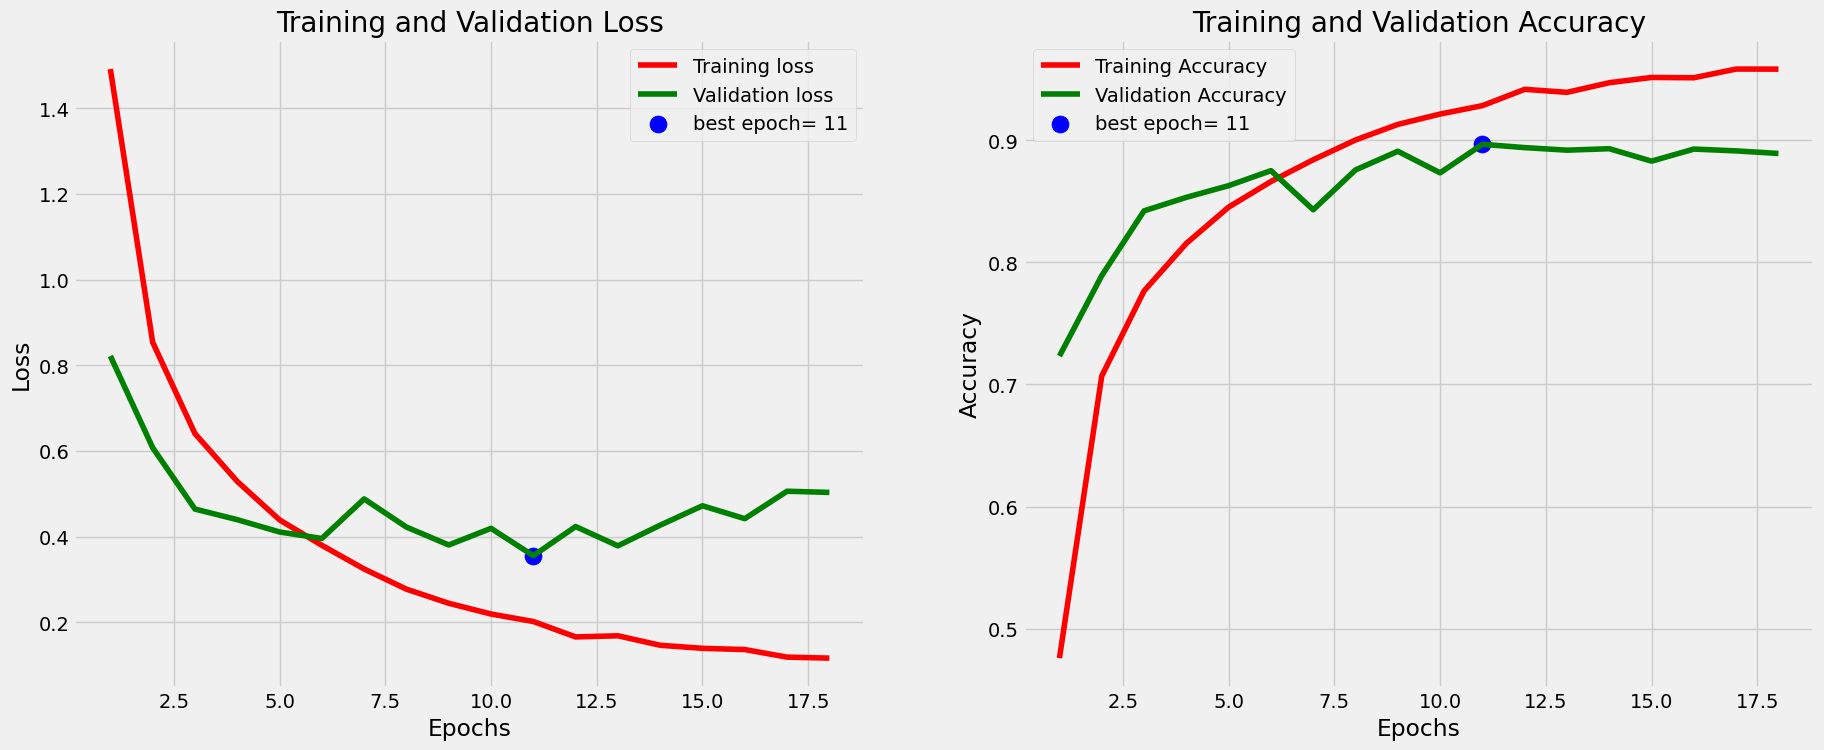

In [129]:
plot_training(history)

In [130]:
test_labels = []
for _, label in test_ds.map(lambda x, y: (x, y)):
    test_labels.append(label.numpy())

105/105 [==============================] - 7s 65ms/step
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.88      0.88      0.88       367
                        Early_blight       0.91      0.85      0.88       316
                         Late_blight       0.82      0.85      0.83       389
                           Leaf_Mold       0.92      0.88      0.90       370
                  Septoria_leaf_spot       0.80      0.83      0.81       359
Spider_mites Two-spotted_spider_mite       0.91      0.98      0.94       224
                         Target_Spot       0.93      0.90      0.91       237
       Tomato_Yellow_Leaf_Curl_Virus       0.99      0.94      0.97       254
                 Tomato_mosaic_virus       0.98      0.96      0.97       313
                             healthy       0.94      0.97      0.96       388
                      powdery_mildew       0.77      0.83      0.80       121

      

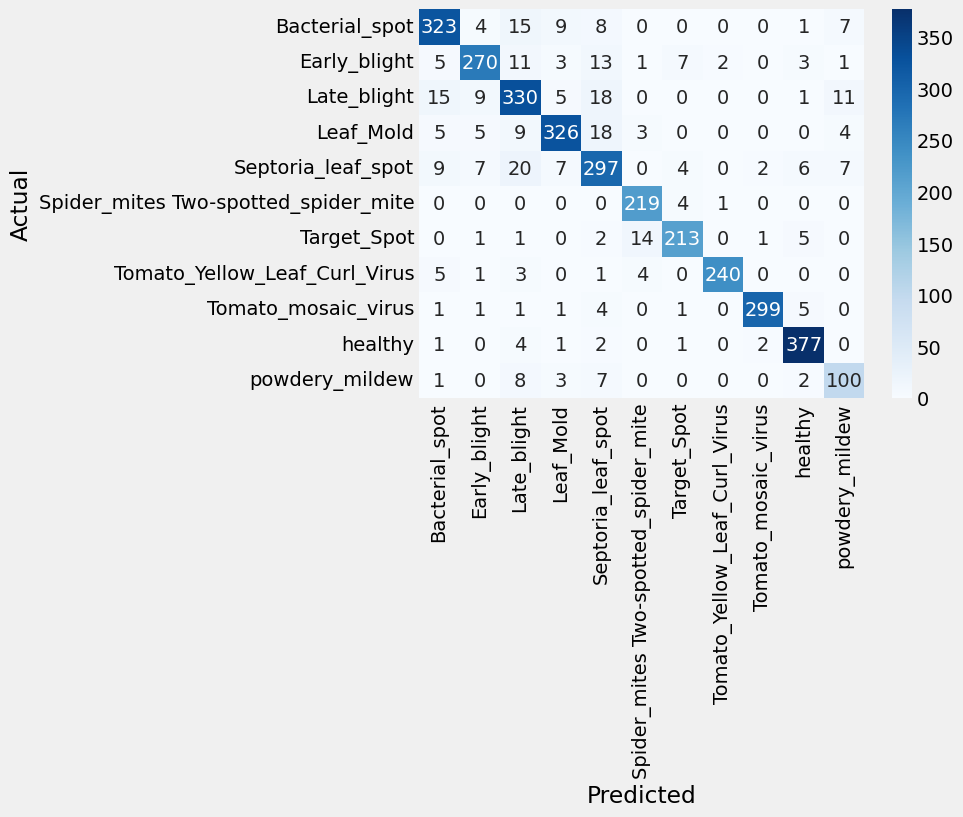

In [131]:
from keras.utils import to_categorical
# convert labels to numerical format
test_labels = np.concatenate([y for x, y in test_ds])
test_labels = np.argmax(test_labels, axis=1)

# predict on test dataset
y_pred_cnn = model.predict(test_ds)

# convert predictions to class labels
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)

# print classification report
print(classification_report(test_labels, y_pred_cnn, target_names=class_names))

# create confusion matrix
cm = confusion_matrix(test_labels, y_pred_cnn)

# plot confusion matrix using heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()